In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D
import numpy as np # For array operations
import matplotlib.pyplot as plt
import pickle
from random import shuffle
import random
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import os
from pathlib import Path
import cv2 as cv

In [ ]:
!pip install unzip
!unzip "/content/drive/MyDrive/archive.zip"

In [3]:
dataset_path = Path('/content/chest_xray')
train_path = dataset_path / 'train'
test_path = dataset_path / 'test'
val_path = dataset_path / 'val'

In [4]:
print(f'Training Normal Samples: {len(os.listdir(train_path / "NORMAL"))}')
print(f'Training Pneumonia Samples: {len(os.listdir(train_path / "PNEUMONIA"))}')
print('---------------------------------')
print(f'Testing Normal Samples: {len(os.listdir(test_path / "NORMAL"))}')
print(f'Testing Pneumonia Samples: {len(os.listdir(test_path / "PNEUMONIA"))}')
print('---------------------------------')
print(f'Validation Normal Samples: {len(os.listdir(val_path / "NORMAL"))}')
print(f'Validation Pneumonia Samples: {len(os.listdir(val_path / "PNEUMONIA"))}')

Training Normal Samples: 1341
Training Pneumonia Samples: 3875
---------------------------------
Testing Normal Samples: 234
Testing Pneumonia Samples: 390
---------------------------------
Validation Normal Samples: 8
Validation Pneumonia Samples: 8


In [5]:
classes = ['NORMAL', 'PNEUMONIA']
img_width = 224
img_height = 224
seed = 42
random.seed(seed)

def resize_image(img_array, height, width):
    return cv.resize(img_array, (height, width))

def plot_image(img_array):
    plt.imshow(img_array, cmap='gray')
    plt.show()

def sep_features_labels(data):
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    return X, y

def reshape(X, y, img_width, img_height):
    X = np.array(X).reshape(-1, img_height, img_width, 1)
    X = np.array(X).astype('float') / 255.0
    y = np.asarray(y).astype('float32').reshape((-1, 1))
    return X, y

def get_data(data_dir, classes, img_width, img_height, samples_to_retreive):
    data = []
    for a_class in classes:
      num_of_images = 0
      path = os.path.join(data_dir, a_class)
      class_num = classes.index(a_class)

      for image in os.listdir(path):
        if num_of_images == samples_to_retreive: break
        img_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
        resized_img_array = resize_image(img_array, img_width, img_height)
        data.append([resized_img_array, class_num])
        num_of_images += 1
               
    return data

In [6]:
from sklearn.model_selection import train_test_split

training_data = get_data(train_path, classes, img_width, img_height, 600)
random.shuffle(training_data)
X_train, y_train = sep_features_labels(training_data)
X_train, y_train = reshape(X_train, y_train, img_width, img_height)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=seed, test_size=0.5)

In [8]:
testing_data = get_data(test_path, classes, img_width, img_height, -1)
random.shuffle(testing_data)
X_test, y_test = sep_features_labels(testing_data)
X_test, y_test = reshape(X_test, y_test, img_width, img_height)

In [9]:
print(f'Training Samples: {X_train.shape}')
print(f'Validation Samples: {X_val.shape}')
print(f'Testing Samples: {X_val.shape}')

Training Samples: (600, 224, 224, 1)
Validation Samples: (600, 224, 224, 1)
Testing Samples: (600, 224, 224, 1)


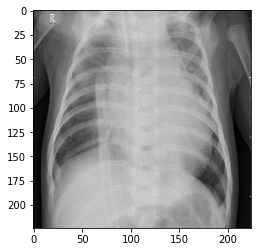

In [10]:
sp_class = 'PNEUMONIA'
index = random.randint(0, len(os.listdir(train_path / sp_class)))
img = cv.imread(os.path.join((train_path / sp_class), os.listdir(train_path / sp_class)[index]), cv.IMREAD_GRAYSCALE) 
img = resize_image(img, img_width, img_height)

plt.imshow(img, cmap='gray')
plt.show()

In [12]:
model = Sequential()
model.add(Conv2D(16, kernel_size=3, input_shape=(img_width, img_height, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      160       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 32)      4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 128)     73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 128)      0         
 2D)                                                  

In [13]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=132, verbose=1)

Epoch 1/50
5/5 [==============================] - 20s 1s/step - loss: 2.2329 - accuracy: 0.5000 - val_loss: 1.0079 - val_accuracy: 0.5100
Epoch 2/50
5/5 [==============================] - 3s 563ms/step - loss: 0.7452 - accuracy: 0.5767 - val_loss: 0.5834 - val_accuracy: 0.6817
Epoch 3/50
5/5 [==============================] - 3s 563ms/step - loss: 0.5039 - accuracy: 0.7800 - val_loss: 0.5593 - val_accuracy: 0.7167
Epoch 4/50
5/5 [==============================] - 3s 566ms/step - loss: 0.4472 - accuracy: 0.7983 - val_loss: 0.3189 - val_accuracy: 0.8833
Epoch 5/50
5/5 [==============================] - 3s 565ms/step - loss: 0.2989 - accuracy: 0.8717 - val_loss: 0.2249 - val_accuracy: 0.9267
Epoch 6/50
5/5 [==============================] - 3s 565ms/step - loss: 0.1967 - accuracy: 0.9250 - val_loss: 0.1874 - val_accuracy: 0.9350
Epoch 7/50
5/5 [==============================] - 3s 568ms/step - loss: 0.1461 - accuracy: 0.9483 - val_loss: 0.2049 - val_accuracy: 0.9417
Epoch 8/50
5/5 [======

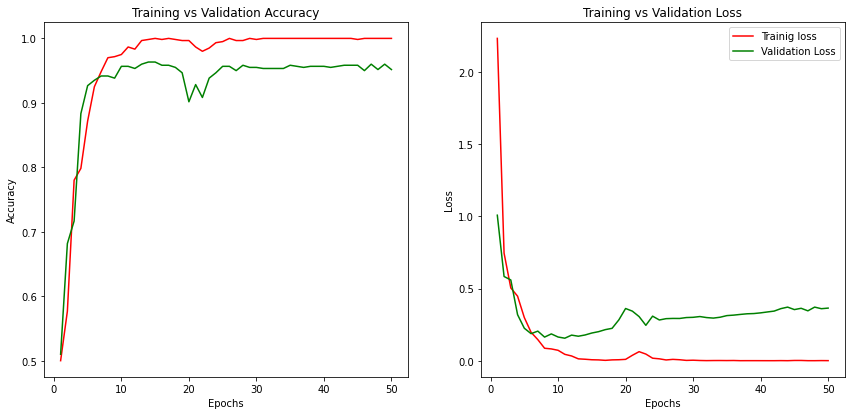

In [14]:
plt.figure(figsize=(30, 30))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.subplot(4, 4, 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.subplot(4, 4, 2)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# It seems that the overfitting seems to occur right after 8th epoch.

In [16]:
# Let us train the model for 8 epochs

model = Sequential()
model.add(Conv2D(16, kernel_size=3, input_shape=(img_width, img_height, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=8, batch_size=132, verbose=1)

Epoch 1/8
5/5 [==============================] - 4s 681ms/step - loss: 2.9623 - accuracy: 0.5333 - val_loss: 0.7189 - val_accuracy: 0.4900
Epoch 2/8
5/5 [==============================] - 3s 589ms/step - loss: 0.7071 - accuracy: 0.5100 - val_loss: 0.6496 - val_accuracy: 0.5183
Epoch 3/8
5/5 [==============================] - 3s 589ms/step - loss: 0.6205 - accuracy: 0.6600 - val_loss: 0.5266 - val_accuracy: 0.8700
Epoch 4/8
5/5 [==============================] - 3s 596ms/step - loss: 0.4525 - accuracy: 0.8283 - val_loss: 0.3313 - val_accuracy: 0.8650
Epoch 5/8
5/5 [==============================] - 3s 595ms/step - loss: 0.3196 - accuracy: 0.8717 - val_loss: 0.2268 - val_accuracy: 0.9200
Epoch 6/8
5/5 [==============================] - 3s 599ms/step - loss: 0.2150 - accuracy: 0.9117 - val_loss: 0.1644 - val_accuracy: 0.9433
Epoch 7/8
5/5 [==============================] - 3s 603ms/step - loss: 0.1638 - accuracy: 0.9500 - val_loss: 0.1822 - val_accuracy: 0.9233
Epoch 8/8
5/5 [============

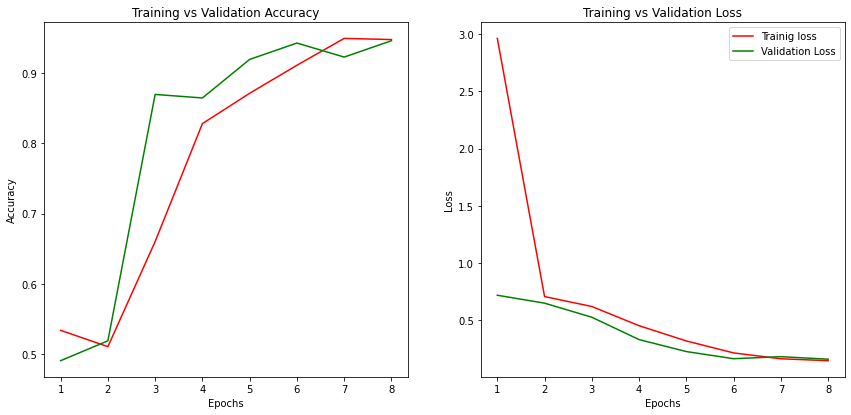

In [17]:
plt.figure(figsize=(30, 30))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.subplot(4, 4, 1)
plt.plot(epochs, acc, color='red', label='Trainig Accuracy')
plt.plot(epochs, val_acc, color='green', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.subplot(4, 4, 2)
plt.plot(epochs, loss, color='red', label='Trainig loss')
plt.plot(epochs, val_loss, color='green', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# It seems that the overfitting seems to occur right after 35th epoch.

In [18]:
# Evaluating the model on the test data:
loss, acc = model.evaluate(X_test, y_test)

20/20 [==============================] - 2s 56ms/step - loss: 0.5173 - accuracy: 0.8141


In [19]:
acc = round(acc, 2)
print(f'Test Accuracy: {(acc * 100)}%')

Test Accuracy: 81.0%
